#Import Libraries

In [1]:
import gensim
import gensim.downloader as api
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
from bs4 import BeautifulSoup
!pip install symspellpy
from symspellpy import SymSpell
!pip install contractions
import contractions
import pkg_resources
import contractions as ct
import re
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 KB 18.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 14.1 MB/s eta 0:00:00


#Load Pre-trained Word2vec Model

In [3]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


#Define Functions Related to Data Processing

In [4]:
# Drop empty & duplicated rows
def init_data(data_frame):
    data_frame.dropna(inplace=True)
    data_frame.drop_duplicates(inplace=True)
    data_frame['star_rating'] = data_frame['star_rating'].astype('int')
    return data_frame

In [5]:
# Init spell checker object
def init_spell_checker():
    sym_spell_obj = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt"
    )
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
    )
    sym_spell_obj.load_dictionary(dictionary_path, term_index=0, count_index=1)
    sym_spell_obj.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

    return sym_spell_obj

In [6]:
# Spell correct the input text
def spell_correct(text):
    input_term = text
    suggestions = sym_spell.lookup_compound(
        input_term, max_edit_distance=2, transfer_casing=True
    )
    return suggestions[0].term

In [7]:
def exclude_words_not_in_w2v(review_body_string):
    word_list = review_body_string.split()
    buffer_string = ""

    for w in word_list:
        if w in wv.vocab:
            buffer_string = buffer_string + w + " "

    buffer_string = re.sub(' +', ' ', buffer_string).strip()
    return buffer_string

In [8]:
def data_cleaning(data_frame):
    for i in range(0, len(data_frame)):
        if data_frame['star_rating'][i] == 1 or data_frame['star_rating'][i] == 2:
            data_frame.loc[i, ['star_rating']] = 0
        elif data_frame['star_rating'][i] == 3:
            data_frame.loc[i, ['star_rating']] = 1
        elif data_frame['star_rating'][i] == 4 or data_frame['star_rating'][i] == 5:
            data_frame.loc[i, ['star_rating']] = 2

        review_text = data_frame['review_body'][i]
        review_text = " ".join(review_text.split())
        # remove un-wanted html tags
        if BeautifulSoup(review_text, "html.parser").find():
            review_text = BeautifulSoup(review_text, "html.parser").get_text("　")
            review_text = " ".join(review_text.split())
        # spell correction
        review_text = spell_correct(review_text)
        # text extend contractions
        review_text = " ".join(review_text.split())
        review_text = ct.fix(review_text)
        # remove non-alphabetical chars
        regex = re.compile('[^a-zA-Z]')
        review_text = regex.sub(' ', review_text)
        # convert to lower case
        review_text = review_text.lower()
        # exclude words not in w2v
        review_text = " ".join(review_text.split())
        review_text = exclude_words_not_in_w2v(review_text)
        # end of data processing
        review_text = " ".join(review_text.split())
        # replace empty string with numpy's nan datatype
        if review_text != "":                  
            data_frame.loc[i, ['review_body']] = review_text
        else:
            data_frame.loc[i, ['review_body']] = np.nan
    return data_frame

In [35]:
# Takes a list of reviews and returns their average W2V embeddings as a numpy array 
def data_prep(data):
    prepared_data = []
    for i in range (0,len(data)):
        words_list = data[i].split()
        vector_sum = np.zeros((300,))
        total_word = len(words_list)
        for word in words_list:
            vector_sum = vector_sum + wv[word]                  
        prepared_data.append(vector_sum/total_word)        
    return np.array(prepared_data)

# Takes a list of reviews and concatenates them for up to 10 words in each review,
# and returns a numpy array with the resulting W2V embeddings
def data_prep2(data):
    prepared_data = np.zeros((len(data), 3000))
    for i in range(0, len(data)):
        words_list = data[i].split()
        index = 0
        for word in words_list:
            if index > 9:
                break
            if word in wv:
                prepared_data[i][index*300:(index+1)*300] = wv[word]
                index += 1
    return prepared_data

# Takes a list of reviews and creates a 3D tensor of W2V embeddings with a fixed
# maximum length of 20 words per review. If a word is not found in the pre-trained
# W2V model, a zero vector is used instead
def data_prep3(data):
    total_reviews = len(data)
    max_review_length = 20
    input_sequence = torch.zeros((total_reviews, max_review_length, 300))
  
    for i in range(total_reviews):  
        words = data[i].split()  
        for j in range(min(len(words), max_review_length)):
            if words[j] in wv.vocab:
                input_sequence[i][j] = torch.from_numpy(wv[words[j]].copy())
            else:
                input_sequence[i][j] = torch.zeros(300)    
    return input_sequence


In [10]:
# Print the training results of Perceptron and SVM 
def generate_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    print("Class 1 Precision: " + str(report[str(0)]['precision']) + ", Class 1 Recall: " + str(
        report[str(0)]['recall']) + ", Class 1 f1-score: " + str(report[str(0)]['f1-score']))
    print("Class 2 Precision: " + str(report[str(1)]['precision']) + ", Class 2 Recall: " + str(
        report[str(1)]['recall']) + ", Class 2 f1-score: " + str(report[str(1)]['f1-score']))
    print("Class 3 Precision: " + str(report[str(2)]['precision']) + ", Class 3 Recall: " + str(
        report[str(2)]['recall']) + ", Class 3 f1-score: " + str(report[str(2)]['f1-score']))
    print("Average Precision: " + str(report['macro avg']['precision']) + ", Averagage Recall: " + str(
        report['macro avg']['recall']) + ", Averagage f1-score: " + str(
        report['macro avg']['f1-score']))
    print("\n")

# Task 1

####Initialization

In [11]:
RANDOM_SAMPLE_SIZE = 20000
sym_spell = init_spell_checker()
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

####Prepare Balanced Dataset

In [14]:
# Read data
############################### remember test and change ###############################
df = pd.read_pickle("/content/drive/MyDrive/Dataset/data.pkl")   
############################### remember test and change ###############################
df = init_data(df).reset_index(drop=True)

# 3-classes dataset
class1_df = df[df['star_rating'] <= 2].sample(RANDOM_SAMPLE_SIZE)
class2_df = df[df['star_rating'] == 3].sample(RANDOM_SAMPLE_SIZE)
class3_df = df[df['star_rating'] >= 4].sample(RANDOM_SAMPLE_SIZE)

# Clean balanced dataset
balanced_df = pd.concat([class1_df, class2_df, class3_df]).reset_index(drop=True)
cleaned_balanced_df = data_cleaning(balanced_df)
cleaned_balanced_df.dropna(inplace=True)

#Task 2a

In [27]:
# 3 examples using pre-trained W2V
example_1 = wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))

ice + sport - walk ~= ('hockey', 0.5072677135467529)
gas + dangerous - stable ~= ('natural_gas', 0.4578143358230591)
cold + rain - sun ~= ('wet_weather', 0.5952470302581787)


#Task 2b

In [28]:
# Train my W2V
sentences = cleaned_balanced_df["review_body"].tolist()
sentences_training = [index.split() for index in sentences ]
my_word2vec = gensim.models.Word2Vec(sentences_training , size=300, window=13, min_count=9)

In [31]:
# 3 examples using my W2V
example_1 = my_word2vec.wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = my_word2vec.wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = my_word2vec.wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))

ice + sport - walk ~= ('aqua', 0.6586734056472778)
gas + dangerous - stable ~= ('cancer', 0.6508302688598633)
cold + rain - sun ~= ('boiling', 0.6218066811561584)


#Prepares the Training & Test Data for Different Tasks

####Split Dataset into Training and Testing Set

In [41]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_balanced_df['review_body'], cleaned_balanced_df['star_rating'], test_size=0.2)

####Prepares Data

In [42]:
import torch

# Test data for task 3, 4 and 5
y_train_np = y_train.to_numpy()
y_test_np =  y_test.to_numpy()

# Training data for task 3 and 4a
X_train_np = data_prep(X_train.to_numpy()) 
X_test_np = data_prep(X_test.to_numpy()) 

# Training data for task 4b
X_train_np_2 = data_prep2(X_train.to_numpy()) 
X_test_np_2 = data_prep2(X_test.to_numpy()) 

# Training data for task 5
X_train_np_3 = data_prep3(X_train.to_numpy()) 
X_test_np_3 = data_prep3(X_test.to_numpy()) 

#Task 3

####Train Perceptron

In [43]:
clf_perceptron = Perceptron()
clf_perceptron = clf_perceptron.fit(X_train_np, y_train_np)
y_pred_perceptron = clf_perceptron.predict(X_test_np)
generate_report(y_test_np, y_pred_perceptron)

Class 1 Precision: 0.8536355051935789, Class 1 Recall: 0.22448472808542339, Class 1 f1-score: 0.3554856468737711
Class 2 Precision: 0.46762837025588183, Class 2 Recall: 0.7009009009009008, Class 2 f1-score: 0.5609806345282241
Class 3 Precision: 0.6098181106982202, Class 3 Recall: 0.7636541758510899, Class 3 f1-score: 0.6781209221400608
Average Precision: 0.6436939953825603, Averagage Recall: 0.5630132682791381, Averagage f1-score: 0.531529067847352




####Train Linear SVC

In [44]:
clf_linear_svc = LinearSVC()
clf_linear_svc = clf_linear_svc.fit(X_train_np, y_train_np)
y_pred_linear_svc = clf_linear_svc.predict(X_test_np)
generate_report(y_test_np, y_pred_linear_svc)

Class 1 Precision: 0.6649622595568542, Class 1 Recall: 0.6781723367270921, Class 1 f1-score: 0.6715023358741087
Class 2 Precision: 0.5714285714285714, Class 2 Recall: 0.557014157014157, Class 2 f1-score: 0.5641293013555787
Class 3 Precision: 0.7259205071933674, Class 3 Recall: 0.7291207445505755, Class 3 f1-score: 0.7275171065493645
Average Precision: 0.654103779392931, Averagage Recall: 0.6547690794306082, Averagage f1-score: 0.6543829145930173




#Task 4a

####Define Functions

In [45]:
# Train and evaluate an MLP model
def Train_an_MLP_and_eval(input_size, hidden_1, hidden_2, use_batchnom,dropout_p, train,validation,test,lr =0.001,wd=0.0,es_num=20,num_epoch=100):    
    # Initialize an MLP model with the given input and hidden layer sizes
    mlp = MLP(input_size, hidden_1, hidden_2, use_batchnom,dropout_p)

    # Define the loss function and optimizer for the model
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.RAdam(mlp.parameters(),lr=lr, weight_decay=wd)

    # Initialize variables for recording training, validation and test losses
    best_loss = float('inf')
    counter = 0
    train_list = []
    valid_list = []
    test_list = [] 
    train_acc_list = []
    test_acc_list = []
    lowest_valid_loss = float('inf')

    # Training loop
    for epoch in range(0, num_epoch): 
        train_loss = 0.0   
        train_correct = 0
        train_total = 0
        # Iterate over the training data and perform forward and backward passes 
        # to update the model weights     
        for i, data in enumerate(train, 0):
            inputs, targets = data
          
            optimizer.zero_grad()
            outputs = mlp(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        # Record train loss and accuracy
        train_list.append(train_loss / len(train))
        train_acc_list.append(train_correct / train_total)

        # Evaluate the model on the validation data and record the validation loss
        valid_loss = 0.0
        mlp.eval()  
        for i, data in enumerate(validation, 0):
            inputs, targets = data
            outputs = mlp(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            valid_loss += loss.item()
        valid_list.append(valid_loss / len(validation))
        
        # Update the lowest validation loss seen so far
        if lowest_valid_loss > valid_loss / len(validation):
            lowest_valid_loss = valid_loss / len(validation)

        # Evaluate the model on the test data and record the test loss
        mlp.eval()  
        testing_loss = 0.0
        testing_correct = 0
        testing_total = 0
        with torch.no_grad():
            for data, target in test:
                output = mlp(data)
                target = target.type(torch.LongTensor)
                loss = loss_function(output, target)
                testing_loss += loss.item() * data.size(0)

                # Calculate test accuracy
                _, predicted = torch.max(output.data, 1)
                testing_total += target.size(0)
                testing_correct += (predicted == target).sum().item()

        testing_loss /= len(test.dataset)
        test_list.append(testing_loss)
        test_acc_list.append(testing_correct / testing_total)

        # If the validation loss hasn't improved in es_num epochs, stop training        
        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
            torch.save(mlp.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter >= es_num:
                print("Early stopping")
                break  
    
    # Use the best model obtained from the early stopping process
    mlp.load_state_dict(torch.load('best_model.pt'))
    test_acc(mlp, test)
    print("Lowest Valid Loss = " + str(lowest_valid_loss))
    plot_loss(train_list, test_list, valid_list)   
    print("\n")
    plot_accuracy(train_acc_list, test_acc_list)    

In [46]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import transforms,datasets
import matplotlib.pyplot as plt

# Calculate and print the accuracy of the model on the given dataset
def test_acc(model, dataloader):
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            outputs = model(data)       
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    accuracy = 100 * correct / total      
    print('Test accuracy: {:.16f}%'.format(accuracy))

# Plot the training, validation, and test losses
def plot_loss(train_loss, test_loss, val_loss):
    epochs = len(train_loss)
    x = range(epochs)

    plt.plot(x, train_loss, label='Training Loss')
    plt.plot(x, test_loss, label='Testing Loss')
    plt.plot(x, val_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the training and testing accuracy
def plot_accuracy(train_acc_list, test_acc_list):
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(test_acc_list, label='Testing Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

####Setup Dataloaders for Task 4a and 4b

In [47]:
# use GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#####   Dataloaders for task 4a #####
BATCH_SIZE = 64
X_train_tensor = torch.Tensor(X_train_np)
X_test_tensor  = torch.Tensor(X_test_np)
y_train_tensor = torch.Tensor(y_train_np)
y_test_tensor = torch.Tensor(y_test_np)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

train_dataset, validation_dataset = random_split(train_dataset,[0.9,0.1])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True) 

#####   Dataloaders for task 4b #####
BATCH_SIZE_2 = 32

X_train_tensor_2 = torch.Tensor(X_train_np_2.astype('float32'))
X_test_tensor_2  = torch.Tensor(X_test_np_2.astype('float32'))

train_dataset_2 = TensorDataset(X_train_tensor_2,y_train_tensor)
test_dataset_2 = TensorDataset(X_test_tensor_2,y_test_tensor)

train_dataset_2, validation_dataset_2 = random_split(train_dataset_2,[0.9,0.1])

train_dataloader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True) 
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True) 
validation_dataloader_2= DataLoader(validation_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True)

Using cuda device


####MLP constructor

In [48]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_1, hidden_2, use_batchnorm, dropout_p=0.0, output_size=3):
        super().__init__()

        # Create a sequence of layers
        self.layers = nn.Sequential(
            # Flatten the input tensor 
            nn.Flatten(),
            # Fully connected layer 
            nn.Linear(input_size, hidden_1),
            # Add batch normalization if True
            nn.BatchNorm1d(hidden_1) if use_batchnorm else nn.Identity(),
            # Apply ReLU activation function
            nn.ReLU(),
            # Apply dropout with probability dropout_p 
            nn.Dropout(dropout_p),
            # Fully connected layer 
            nn.Linear(hidden_1, hidden_2),
            # Add batch normalization if True
            nn.BatchNorm1d(hidden_2) if use_batchnorm else nn.Identity(),
            # Apply ReLU activation function
            nn.ReLU(),
            # Apply dropout with probability dropout_p
            nn.Dropout(dropout_p),
            # Fully connected layer 
            nn.Linear(hidden_2, output_size)
        )

    def forward(self, x):        
        return self.layers(x)

####Train MLP 4a

Early stopping
Test accuracy: 66.8862025844101709%
Lowest Valid Loss = 0.7416303757826487


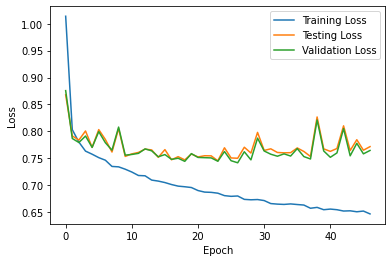

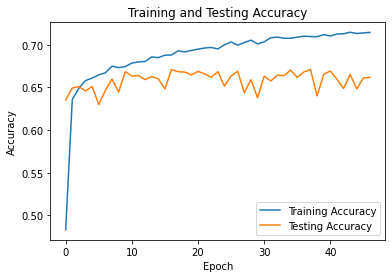

In [49]:
Train_an_MLP_and_eval(300,100,10,True,0.5,train_dataloader,validation_dataloader,test_dataloader,wd=0.001)

####Train MLP 4b

Early stopping
Test accuracy: 56.1233847436431859%
Lowest Valid Loss = 0.8990890645980835


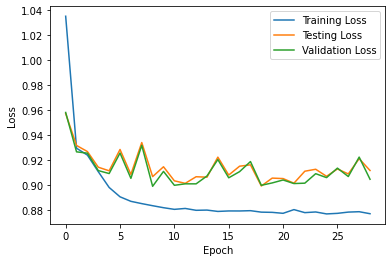

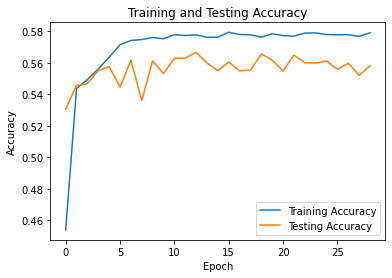

In [50]:
Train_an_MLP_and_eval(3000,100,10,True,0.5,train_dataloader_2,validation_dataloader_2,test_dataloader_2,wd = 0.01)

# Task 5

####Constructors for RNN, GRU, and LSTM

In [51]:
class RNN(nn.Module):
    def __init__(self, input_size, hid_dim, output_dim):
        super().__init__()
        # A bidirectional RNN should be better for Amazon reviews
        self.rnn = nn.RNN(input_size, hid_dim, batch_first=True, bidirectional=True)
        # Define a linear layer to generate the final output from the concatenated hidden state
        self.fc = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, x):
        output, hidden = self.rnn(x)
        # The RNN returns a tensor with shape (num_layers * num_directions, batch_size, hidden_size)
        # In this case, we only want the last hidden state of both directions, which is why -2 and -1 is used
        last_hidden_fw = hidden[-2, :, :]
        last_hidden_bw = hidden[-1, :, :]
        # Concatenate the last hidden states along the second dimension
        hidden_concat = torch.cat([last_hidden_fw, last_hidden_bw], dim=1)
        out = self.fc(hidden_concat)
        return out


class GRU(nn.Module):
    def __init__(self, input_size, hid_dim, output_dim):
        super().__init__()
        # A bidirectional RNN should be better for Amazon reviews
        self.gru = nn.GRU(input_size, hid_dim, batch_first=True, bidirectional=True)
        # Define a linear layer to generate the final output from the concatenated hidden state
        self.fc = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, x):
        output, hidden = self.gru(x)
        # The GRU also returns a tensor with shape (num_layers * num_directions, batch_size, hidden_size)
        # However, in this case, the first dimension corresponds to the different gates in the GRU
        # To get the last hidden state of both directions, we use 0 and 1
        last_hidden_fw = hidden[0, :, :]
        last_hidden_bw = hidden[1, :, :]
        # Concatenate the last hidden states along the second dimension
        hidden_concat = torch.cat([last_hidden_fw, last_hidden_bw], dim=1)
        out = self.fc(hidden_concat)
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hid_dim, output_dim):
        super().__init__()
        # A bidirectional RNN should be better for Amazon reviews
        self.lstm = nn.LSTM(input_size, hid_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        # The LSTM also returns a tuple containing the hidden state and the cell state
        # We only want the last hidden state of both directions, which is why -2 and -1 is used
        last_hidden_fw = hidden[-2, :, :]
        last_hidden_bw = hidden[-1, :, :]
        # Concatenate the last hidden states along the second dimension
        hidden_concat = torch.cat([last_hidden_fw, last_hidden_bw], dim=1)
        out = self.fc(hidden_concat)
        return out

#### Function to Train a RNN

In [52]:
def Train_a_RNN_and_eval(model_abbrv,input_size, hidden_1, output_size ,train, validation, test, num_epochs=100):
    if model_abbrv == "rnn": 
        model = RNN(input_size, hidden_1, output_size)
    elif model_abbrv == "gru":
        model = GRU(input_size,  hidden_1,  output_size)
    elif model_abbrv == "lstm":
        model = LSTM(input_size, hidden_1, output_size)
   
    optimizer = torch.optim.RAdam(model.parameters())
    loss_function = nn.CrossEntropyLoss() 
    best_loss = float('inf')
    counter = 0
    train_list = []
    valid_list = []
    test_list = []
    train_acc_list = []
    test_acc_list = []
    lowest_valid_loss = float('inf')

    for epoch in range(num_epochs):        
        train_loss = 0.0
        train_total = 0
        train_correct = 0
        for i, batch in enumerate(train, 0):
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        # record train loss and accuracy
        train_list.append(train_loss / len(train))
        train_acc_list.append(train_correct / train_total)

        # record validation loss
        valid_loss = 0.0
        model.eval()  
        for i, data in enumerate(validation, 0):
            inputs, targets = data
            outputs = model(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            valid_loss += loss.item()
        valid_list.append(valid_loss / len(validation))
        
        # update lowest validation loss
        if lowest_valid_loss > valid_loss / len(validation):
            lowest_valid_loss = valid_loss / len(validation)

         # record test loss
        model.eval()  
        testing_loss = 0.0
        testing_total = 0.0
        testing_correct = 0.0
        with torch.no_grad():
            for data, target in test:
                output = model(data)
                target = target.type(torch.LongTensor)
                loss = loss_function(output, target)
                testing_loss += loss.item() * data.size(0)

                # Calculate test accuracy
                _, predicted = torch.max(output.data, 1)
                testing_total += target.size(0)
                testing_correct += (predicted == target).sum().item()

        testing_loss /= len(test.dataset)
        test_list.append(testing_loss)
        test_acc_list.append(testing_correct / testing_total)

        # early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter >= 20:
                print("Early stopping")
                break
  
    # Use the best model obtained from the early stopping process
    model.load_state_dict(torch.load('best_model.pt'))
    test_acc(model, test)
    print("Lowest Valid Loss = " + str(lowest_valid_loss)) 
    plot_loss(train_list, test_list, valid_list)      
    print("\n")
    plot_accuracy(train_acc_list, test_acc_list) 

####Setup Dataloaders for Task 5

In [56]:
BATCH_SIZE_3 = 32

X_train_tensor_3 = torch.Tensor(X_train_np_3).to(dtype=torch.float32)
X_test_tensor_3  = torch.Tensor(X_test_np_3).to(dtype=torch.float32)

train_dataset_3 = TensorDataset(X_train_tensor_3, y_train_tensor)
test_dataset_3 = TensorDataset(X_test_tensor_3, y_test_tensor)

train_dataset_3, validation_dataset_3 = random_split(train_dataset_3, [0.9, 0.1])

train_dataloader_3 = DataLoader(train_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True) 
test_dataloader_3 = DataLoader(test_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True) 
validation_dataloader_3 = DataLoader(validation_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True)

####Task 5a

Early stopping
Test accuracy: 61.9924968736973767%
Lowest Valid Loss = 0.8127997370560964


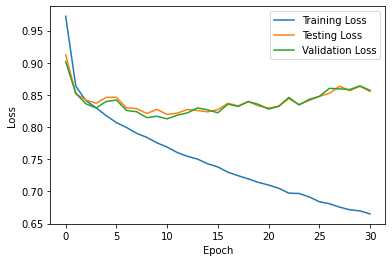

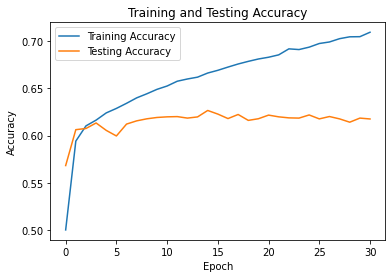

In [57]:
Train_a_RNN_and_eval("rnn",300, 20, 3, train_dataloader_3, validation_dataloader_3, test_dataloader_3)

####Task 5b

Early stopping
Test accuracy: 65.5022926219258039%
Lowest Valid Loss = 0.7512034686406454


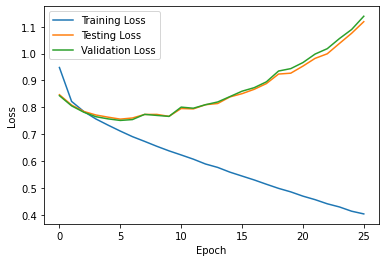

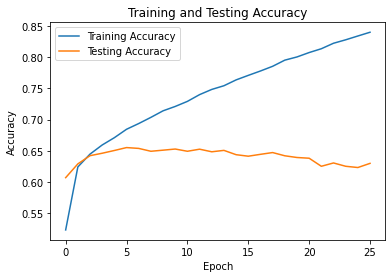

In [58]:
Train_a_RNN_and_eval("gru",300, 20, 3, train_dataloader_3, validation_dataloader_3, test_dataloader_3)

####Task 5c

Early stopping
Test accuracy: 65.1854939558149198%
Lowest Valid Loss = 0.7527121152480444


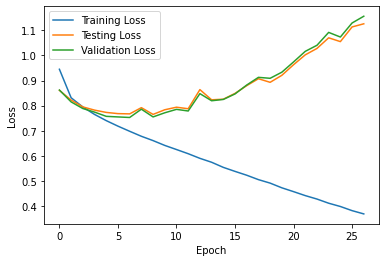

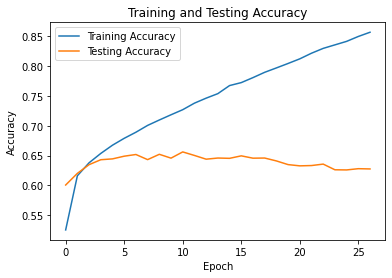

In [59]:
Train_a_RNN_and_eval("lstm",300, 20, 3, train_dataloader_3, validation_dataloader_3, test_dataloader_3)